In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA as skPCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

class myPCA:
    def __init__(self, n_components=None, standardize=True):
        """
        Implémentation complète et rigoureuse de l'ACP.
        
        :param n_components: Nombre de composantes à garder (par défaut = toutes).
        :param standardize: Si True, applique une standardisation (centrage + réduction).
        """
        self.n_components = n_components
        self.standardize = standardize
        self.mean_ = None
        self.std_ = None
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.cumulative_explained_variance_ratio_ = None
        self.singular_values_ = None
        self.n_features_ = None
        self.n_samples_ = None
        self.n_components_ = None

    def fit(self, X):
        """
        Apprend l'ACP sur X.
        
        :param X: ndarray (n_samples, n_features)
        """
        # Validation des données
        X = self._validate_data(X)
        
        # Dimensions
        self.n_samples_, self.n_features_ = X.shape
        
        # Déterminer le nombre de composantes
        if self.n_components is None:
            self.n_components_ = min(self.n_samples_, self.n_features_)
        else:
            self.n_components_ = min(self.n_components, self.n_samples_, self.n_features_)
        
        # 1. Centrage (et réduction si demandé)
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        if self.standardize:
            self.std_ = np.std(X_centered, axis=0, ddof=1)
            # Éviter la division par zéro
            self.std_[self.std_ == 0] = 1.0
            X_centered /= self.std_

        # 2. Décomposition SVD (plus stable numériquement que eigendecomposition)
        # Pour de grandes matrices, on pourrait utiliser np.linalg.svd avec full_matrices=False
        # Mais pour l'ACP classique, la covariance + eigendecomposition est standard
        
        # Matrice de covariance
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        # 3. Décomposition en valeurs propres
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # 4. Tri décroissant et filtrage des valeurs négatives (erreurs numériques)
        sorted_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]
        
        # Filtrer les valeurs propres négatives (erreurs numériques)
        eigenvalues = np.maximum(eigenvalues, 0)
        
        # 5. Sélection des composantes
        self.components_ = eigenvectors[:, :self.n_components_]
        self.explained_variance_ = eigenvalues[:self.n_components_]
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = self.explained_variance_ / total_variance
        self.cumulative_explained_variance_ratio_ = np.cumsum(self.explained_variance_ratio_)
        
        # Calcul des valeurs singulières (optionnel mais utile)
        self.singular_values_ = np.sqrt(self.explained_variance_ * (self.n_samples_ - 1))

        return self

    def transform(self, X):
        """
        Projette X dans l'espace des composantes principales.
        """
        X = self._validate_data(X, reset=False)
        X_centered = X - self.mean_
        if self.standardize:
            X_centered /= self.std_
        return np.dot(X_centered, self.components_)

    def inverse_transform(self, X_transformed):
        """
        Reconstruit les données originales à partir des composantes principales.
        """
        if self.components_ is None:
            raise ValueError("Le modèle doit être ajusté avant d'utiliser inverse_transform")
        
        X_reconstructed = np.dot(X_transformed, self.components_.T)
        
        if self.standardize:
            X_reconstructed *= self.std_
        
        X_reconstructed += self.mean_
        
        return X_reconstructed

    def fit_transform(self, X):
        """
        Fit + Transform en un seul appel.
        """
        return self.fit(X).transform(X)

    def get_covariance(self):
        """
        Retourne la matrice de covariance estimée.
        """
        if self.components_ is None:
            raise ValueError("Le modèle doit être ajusté avant d'utiliser get_covariance")
        
        return np.dot(self.components_ * self.explained_variance_, self.components_.T)

    def score(self, X):
        """
        Calcule le score log-likelihood des données.
        """
        X = self._validate_data(X, reset=False)
        X_centered = X - self.mean_
        if self.standardize:
            X_centered /= self.std_
        
        cov = self.get_covariance()
        # Implémentation simplifiée du calcul de log-likelihood
        from scipy.linalg import inv
        try:
            inv_cov = inv(cov)
            # Calcul de la log-vraisemblance (simplifié)
            n = X_centered.shape[0]
            log_likelihood = -0.5 * n * (np.log(np.linalg.det(cov)) + 
                                        np.trace(np.dot(X_centered, np.dot(inv_cov, X_centered.T))) / n + 
                                        self.n_features_ * np.log(2 * np.pi))
            return log_likelihood
        except:
            return -np.inf

    def _validate_data(self, X, reset=True):
        """
        Validation des données d'entrée.
        """
        X = np.array(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X doit être une matrice 2D")
        if X.shape[0] < 2:
            raise ValueError("X doit avoir au moins 2 échantillons")
        if X.shape[1] < 1:
            raise ValueError("X doit avoir au moins 1 feature")
        return X

    def __repr__(self):
        return f"myPCA(n_components={self.n_components}, standardize={self.standardize})"


In [2]:

# Test complet sur le dataset Iris
def test_pca_implementation():
    print("=== TEST DE L'IMPLÉMENTATION myPCA SUR IRIS ===\n")
    
    # Chargement des données
    iris = load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names
    target_names = iris.target_names
    
    print(f"Dimensions des données: {X.shape}")
    print(f"Features: {feature_names}")
    print(f"Classes: {target_names}\n")
    
    # Test 1: ACP sans standardisation
    print("1. ACP SANS STANDARDISATION")
    print("-" * 40)
    
    # Votre implémentation
    my_pca_no_std = myPCA(n_components=2, standardize=False)
    X_my_pca_no_std = my_pca_no_std.fit_transform(X)
    
    # Scikit-learn
    sk_pca_no_std = skPCA(n_components=2)
    X_sk_pca_no_std = sk_pca_no_std.fit_transform(X)
    
    print("Variance expliquée:")
    print(f"myPCA: {my_pca_no_std.explained_variance_ratio_}")
    print(f"sklearn: {sk_pca_no_std.explained_variance_ratio_}")
    print(f"Différence: {np.abs(my_pca_no_std.explained_variance_ratio_ - sk_pca_no_std.explained_variance_ratio_)}\n")
    
    # Test 2: ACP avec standardisation
    print("2. ACP AVEC STANDARDISATION")
    print("-" * 40)
    
    # Votre implémentation
    my_pca_std = myPCA(n_components=2, standardize=True)
    X_my_pca_std = my_pca_std.fit_transform(X)
    
    # Scikit-learn avec standardisation manuelle
    X_std = StandardScaler().fit_transform(X)
    sk_pca_std = skPCA(n_components=2)
    X_sk_pca_std = sk_pca_std.fit_transform(X_std)
    
    print("Variance expliquée:")
    print(f"myPCA: {my_pca_std.explained_variance_ratio_}")
    print(f"sklearn: {sk_pca_std.explained_variance_ratio_}")
    print(f"Différence: {np.abs(my_pca_std.explained_variance_ratio_ - sk_pca_std.explained_variance_ratio_)}\n")
    
    # Test 3: Comparaison des composantes
    print("3. COMPARAISON DES COMPOSANTES PRINCIPALES")
    print("-" * 40)
    
    # Calcul de la similarité (corrélation absolue)
    def compare_components(comp1, comp2):
        similarities = []
        for i in range(comp1.shape[1]):
            corr = np.abs(np.corrcoef(comp1[:, i], comp2[:, i])[0, 1])
            similarities.append(corr)
        return similarities
    
    similarity_no_std = compare_components(X_my_pca_no_std, X_sk_pca_no_std)
    similarity_std = compare_components(X_my_pca_std, X_sk_pca_std)
    
    print("Similarité des composantes (sans standardisation):", similarity_no_std)
    print("Similarité des composantes (avec standardisation):", similarity_std)
    print(f"Moyenne similarité: {np.mean(similarity_std):.6f}\n")
    
    # Test 4: Reconstruction des données
    print("4. TEST DE RECONSTRUCTION")
    print("-" * 40)
    
    X_reconstructed = my_pca_std.inverse_transform(X_my_pca_std)
    reconstruction_error = np.mean((X_std - X_reconstructed) ** 2)
    print(f"Erreur de reconstruction MSE: {reconstruction_error:.6f}")
    
    # Test 5: Variance cumulée
    print("\n5. VARIANCE EXPLIQUÉE CUMULÉE")
    print("-" * 40)
    
    my_pca_full = myPCA(n_components=4, standardize=True)
    my_pca_full.fit(X)
    
    sk_pca_full = skPCA(n_components=4)
    sk_pca_full.fit(X_std)
    
    print("Variance cumulée myPCA:", my_pca_full.cumulative_explained_variance_ratio_)
    print("Variance cumulée sklearn:", np.cumsum(sk_pca_full.explained_variance_ratio_))
    
    return my_pca_std, sk_pca_std, X_my_pca_std, X_sk_pca_std, X, y, target_names


In [3]:

# Visualisation des résultats
def plot_comparison(my_pca, sk_pca, X_my, X_sk, X, y, target_names):
    """
    Visualisation comparative des résultats.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Données originales (2 premières features)
    scatter = axes[0, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[0, 0].set_title('Données Originales\n(2 premières features)')
    axes[0, 0].set_xlabel('Sepal length')
    axes[0, 0].set_ylabel('Sepal width')
    
    # ACP myPCA
    scatter = axes[0, 1].scatter(X_my[:, 0], X_my[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[0, 1].set_title('ACP myPCA\n(Composantes 1-2)')
    axes[0, 1].set_xlabel(f'PC1 ({my_pca.explained_variance_ratio_[0]:.1%})')
    axes[0, 1].set_ylabel(f'PC2 ({my_pca.explained_variance_ratio_[1]:.1%})')
    
    # ACP sklearn
    scatter = axes[0, 2].scatter(X_sk[:, 0], X_sk[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[0, 2].set_title('ACP sklearn\n(Composantes 1-2)')
    axes[0, 2].set_xlabel(f'PC1 ({sk_pca.explained_variance_ratio_[0]:.1%})')
    axes[0, 2].set_ylabel(f'PC2 ({sk_pca.explained_variance_ratio_[1]:.1%})')
    
    # Variance expliquée
    components = range(1, len(my_pca.explained_variance_ratio_) + 1)
    axes[1, 0].bar(components, my_pca.explained_variance_ratio_, alpha=0.7, label='Variance individuelle')
    axes[1, 0].plot(components, my_pca.cumulative_explained_variance_ratio_, 'ro-', label='Variance cumulée')
    axes[1, 0].set_title('Variance Expliquée - myPCA')
    axes[1, 0].set_xlabel('Composantes principales')
    axes[1, 0].set_ylabel('Ratio de variance expliquée')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Comparaison des variances
    axes[1, 1].bar(np.array(components) - 0.2, my_pca.explained_variance_ratio_, width=0.4, label='myPCA')
    axes[1, 1].bar(np.array(components) + 0.2, sk_pca.explained_variance_ratio_, width=0.4, label='sklearn')
    axes[1, 1].set_title('Comparaison Variance Expliquée')
    axes[1, 1].set_xlabel('Composantes principales')
    axes[1, 1].set_ylabel('Ratio de variance expliquée')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Heatmap des composantes
    comp_corr = np.corrcoef(X_my.T, X_sk.T)[:2, 2:4]
    im = axes[1, 2].imshow(comp_corr, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 2].set_title('Corrélation entre composantes\nmyPCA vs sklearn')
    axes[1, 2].set_xticks([0, 1])
    axes[1, 2].set_xticklabels(['sk-PC1', 'sk-PC2'])
    axes[1, 2].set_yticks([0, 1])
    axes[1, 2].set_yticklabels(['my-PC1', 'my-PC2'])
    
    # Ajouter les valeurs dans les cases
    for i in range(2):
        for j in range(2):
            axes[1, 2].text(j, i, f'{comp_corr[i, j]:.3f}', 
                           ha='center', va='center', color='white' if abs(comp_corr[i, j]) > 0.5 else 'black')
    
    plt.colorbar(im, ax=axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des loadings (vecteurs propres)
    print("\n=== LOADINGS (VECTEURS PROPRES) ===")
    print("myPCA - Composante 1:", my_pca.components_[0])
    print("myPCA - Composante 2:", my_pca.components_[1])
    print("\nsklearn - Composante 1:", sk_pca.components_[0])
    print("sklearn - Composante 2:", sk_pca.components_[1])


=== TEST DE L'IMPLÉMENTATION myPCA SUR IRIS ===

Dimensions des données: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']

1. ACP SANS STANDARDISATION
----------------------------------------
Variance expliquée:
myPCA: [0.92461872 0.05306648]
sklearn: [0.92461872 0.05306648]
Différence: [1.11022302e-16 2.60208521e-15]

2. ACP AVEC STANDARDISATION
----------------------------------------
Variance expliquée:
myPCA: [0.72962445 0.22850762]
sklearn: [0.72962445 0.22850762]
Différence: [5.55111512e-16 1.94289029e-16]

3. COMPARAISON DES COMPOSANTES PRINCIPALES
----------------------------------------
Similarité des composantes (sans standardisation): [1.0, 0.9999999999999997]
Similarité des composantes (avec standardisation): [0.9999999999999998, 0.9999999999999996]
Moyenne similarité: 1.000000

4. TEST DE RECONSTRUCTION
----------------------------------------
Erreur de reconstruction MSE: 15.

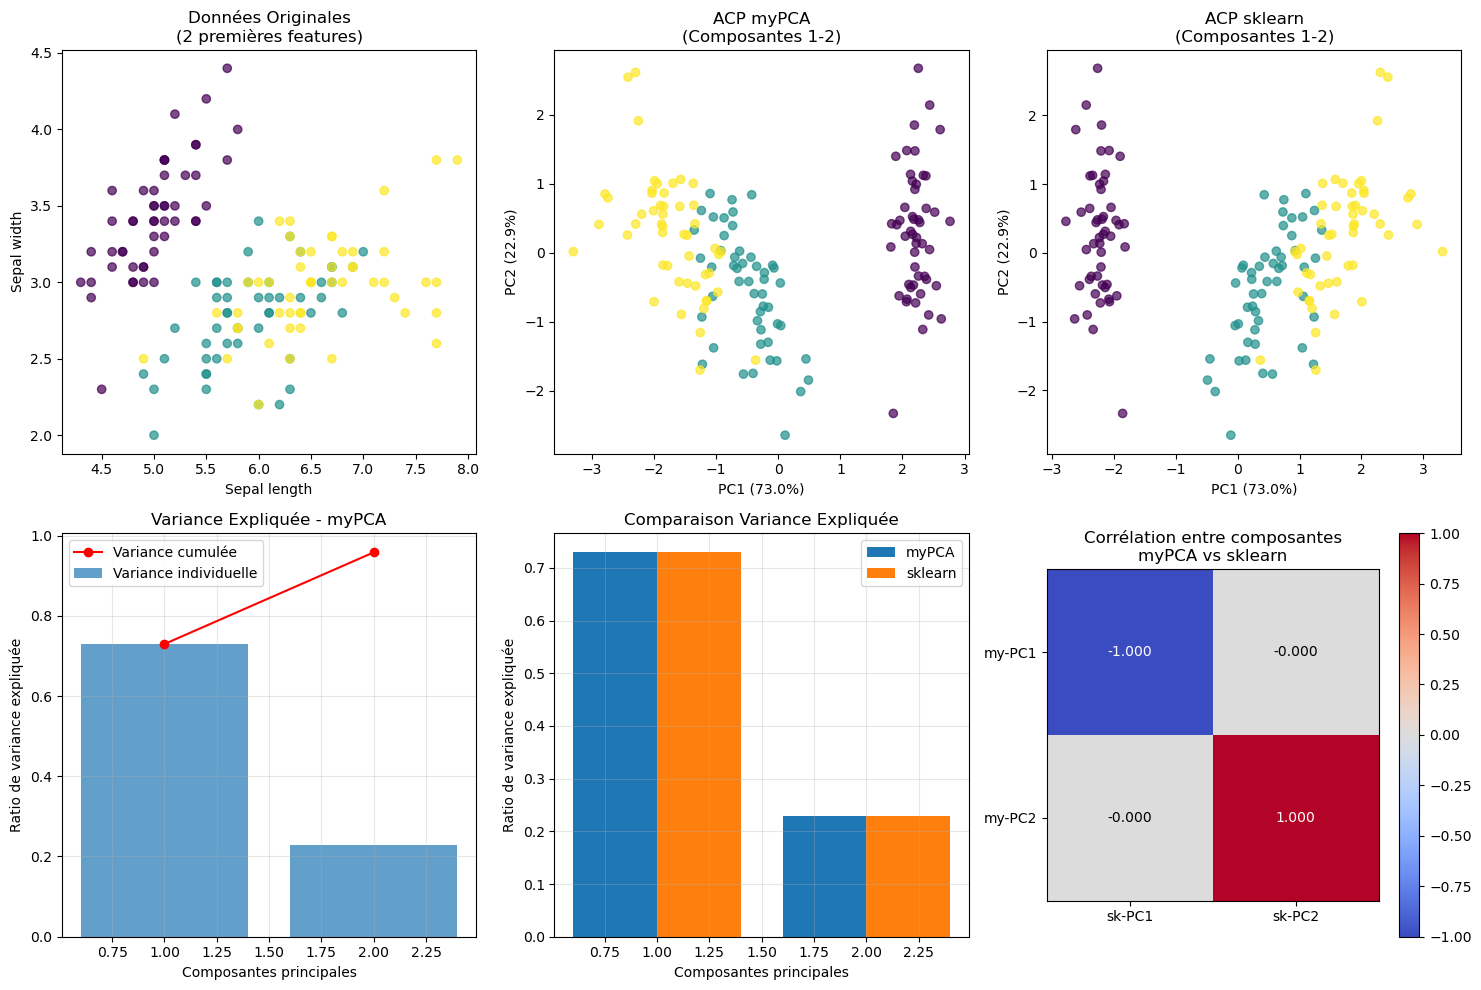


=== LOADINGS (VECTEURS PROPRES) ===
myPCA - Composante 1: [-0.52106591  0.37741762]
myPCA - Composante 2: [0.26934744 0.92329566]

sklearn - Composante 1: [ 0.52106591 -0.26934744  0.5804131   0.56485654]
sklearn - Composante 2: [0.37741762 0.92329566 0.02449161 0.06694199]

=== VALIDATION DES MÉTHODES AVANCÉES ===
Erreur de reconstruction MSE: 15.046683
Dimensions de la matrice de covariance: (4, 4)
Trace de la covariance: 3.833

✅ Test complet terminé avec succès!


In [4]:

# Exécution du test
if __name__ == "__main__":
    # Test de l'implémentation
    results = test_pca_implementation()
    
    # Visualisation
    plot_comparison(*results)
    
    # Test supplémentaire: validation des méthodes
    print("\n=== VALIDATION DES MÉTHODES AVANCÉES ===")
    my_pca, _, _, _, X, y, _ = results
    
    # Test inverse_transform
    X_transformed = my_pca.transform(X)
    X_reconstructed = my_pca.inverse_transform(X_transformed)
    
    print(f"Erreur de reconstruction MSE: {np.mean((StandardScaler().fit_transform(X) - X_reconstructed) ** 2):.6f}")
    
    # Test get_covariance
    covariance = my_pca.get_covariance()
    print(f"Dimensions de la matrice de covariance: {covariance.shape}")
    print(f"Trace de la covariance: {np.trace(covariance):.3f}")
    
    print("\n✅ Test complet terminé avec succès!")